# Overflow

In [1]:
%matplotlib inline

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import lib
import os
from netCDF4 import Dataset

Load Petersen's data for plots.

In [2]:
data = scipy.io.loadmat('../data/c18hijklmfgnopqrs_dRPEdt.mat')

Horizontal viscosities used for experiments, and calculate RPE rate of change. Grid Reynolds numbers are calculated from the horizontal viscosity, using a theoretical front speed of 1.57m/s.

In [3]:
topod = os.path.expanduser('~/phd/spurious/config/flow_downslope/input.nc')

In [4]:
nu_h = ['0.01', '0.1', '1', '10', '100', '1000']

In [12]:
drpe = np.array([lib.drpe_dt('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_KH{}/prog.nc'.format(nu), topod) for nu in nu_h])
drpe_sig = np.array([lib.drpe_dt('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_sigma_KH{}/prog.nc'.format(nu), topod) for nu in nu_h])
gridRe = 1.57 * 1e3 / np.array(list(map(float, nu_h)))

In [13]:
# average drpe from 13-37 hours
with Dataset('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_KH{}/prog.nc'.format(nu_h[0]), 'r') as d:
    t = d.variables['Time'][:]
    mean_drpe = np.mean(drpe[:, np.where((13 < t) & (t < 37))[0]], axis=1)
    mean_drpe_sig = np.mean(drpe_sig[:, np.where((13 < t) & (t < 37))[0]], axis=1)

# Figure 5

Rate of change of RPE for the overflow test case for various models across the range of grid Reynolds numbers tested. For the moment, it seems like MOM6 performs pretty poorly here. This is something to look into, because it seems to be an unlikely result.

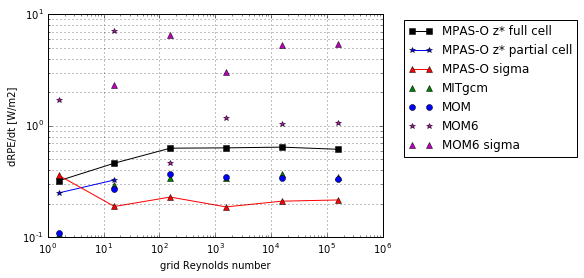

In [14]:
ind = [slice(0,6), slice(6,8), slice(8,14)]
m = "s*^"
c = "kbr"
for j in range(3):
    gridRe = data['grid_spacing'][0,0] * data['vel_scale'][0,0] / data['nu_h'][0,ind[j]]
    plt.loglog(gridRe, data['meanDrpeDt'][0,ind[j]], '-', marker=m[j], color=c[j])
    
plt.loglog(data['mitgcm_Re'][0,:], data['mitgcm_drpe_dt'][:,0], '^g')
plt.loglog(data['mom_Re'][0,:], data['mom_drpe_dt'][:,0], 'ob')

plt.loglog(gridRe, mean_drpe, 'm*')
plt.loglog(gridRe, mean_drpe_sig, 'm^')

plt.grid(which='both', axis='y')
plt.grid(axis='x')

plt.xlabel('grid Reynolds number')
plt.ylabel('dRPE/dt [W/m2]')
plt.legend(['MPAS-O z* full cell', 'MPAS-O z* partial cell', 'MPAS-O sigma', 'MITgcm', 'MOM', 'MOM6', 'MOM6 sigma'],
           bbox_to_anchor=(1.6, 1.0))
#plt.gca().set_xlim(1, 1e6)
#plt.gca().set_ylim(.08, 5)

# RPE Norm

This plot doesn't appear in the paper, but we seem to have the data available, so let's see if we can work out the dRPE/dt discrepancy from here. We try calculating the RPE both including and excluding the topography. It seems like it should make no difference, but there must be a slight precision error with the code including topography that causes the weird bumps.

In [11]:
import importlib
importlib.reload(lib)

<module 'lib' from '/home/users/AngusGibson/phd/spurious/analysis/lib.py'>

In [15]:
norm = True

# include topography
#rpe_t = [lib.rpe_norm('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_KH{}/prog.nc'.format(nu), step=1, ft=topod, norm=norm) for nu in nu_h]
# don't include topography
rpe_nt = [lib.rpe_norm('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_KH{}/prog.nc'.format(nu), step=1, norm=norm) for nu in nu_h]

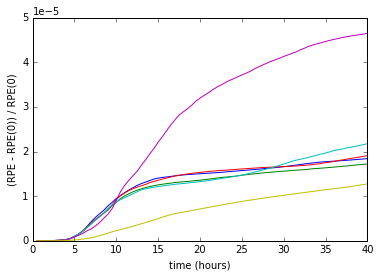

In [16]:
for t, r in rpe_nt:
    plt.plot(t, r)
    
plt.xlabel('time (hours)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if norm:
    plt.ylabel('(RPE - RPE(0)) / RPE(0)')
else:
    plt.ylabel('RPE')

We can compare to the Petersen's normalised RPE data:

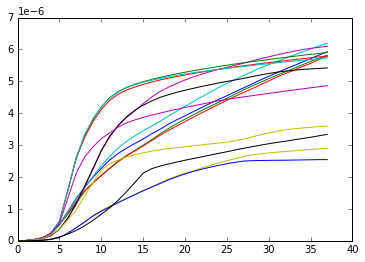

In [61]:
plt.plot(data['time'][0,:] / 3600, data['rpeNorm'])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# dRPE/dt split (not current!)

Let's see if we can figure out where the issue lies with a horizontal/vertical split of the RPE rate of change. According to this, it's horizontally dominated, which is perhaps expected from the lock exchange case, and ALE isn't going to do any convective adjustment that would increase its contribution.

In [18]:
drpe_s = np.array([lib.drpe_dt_split('../mine/flow_downslope_KH{}.nc'.format(nu)) for nu in nu_h])

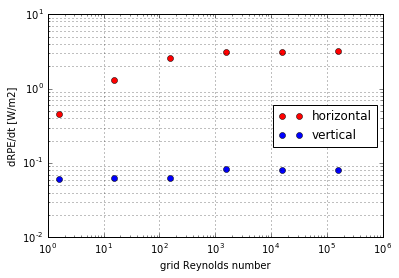

In [23]:
for k in range(len(nu_h)):
    plt.loglog(gridRe[k], drpe_s[k,0].mean(), 'ro')
    plt.loglog(gridRe[k], drpe_s[k,1].mean(), 'bo')
    
plt.legend(['horizontal', 'vertical'], loc='center right')
plt.xlabel('grid Reynolds number')
plt.ylabel('dRPE/dt [W/m2]')
plt.grid(which='both', axis='y')
plt.grid()